# Multiclass classification from CSV file

### Basic Modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle

In [2]:
from pathlib import Path
PATH = Path('./data')

## Data preparation

### Data import from CSV file 
Read file into a pandas dataframe.

In [89]:
df = pd.read_csv(PATH/'training.csv')

In [90]:
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [91]:
df['Label'] = df['Label'].map({'s':1, 'b':0})
df.rename(index=str, columns={"Weight": "gen_weight", 'PRI_met': 'PRI_met_pt', 'Label':'gen_target'}, inplace=True)

### Preprocessing
Having imported the data, we now need to further process it into form suitable for training the classifier.

We can start by moving a Cartesian coordinate system; the HEP standard of $p_T,\ \eta,\ \phi$ can be a bit tricky, since $\phi$ is cyclical in nature, and $\eta$ is highly non-linear. Additionally, since the class of each event is invariant under transformations of the absolute orientation of each event, we can remove several symetries in the data by rotating each event to have the same orientation. However, in this example we will leave will instead randomly rotate the event during training and testing (train-time/test-time data augmentation).

`proc_event` has options to set all events to have `ref_vec_0` at $\phi=0$ and be always in the positive $\eta$ region. The remaining symmetry of transverse reflection can be fixed by setting `ref_vec_1` to be in the positive $\phi$ region. The vectors can then transformed into Cartesian system via `use_cartesian` flag. The original vectors are automatically dropped, but can be kept if added to `keep_feat`. It can sometimes be useful to keep the absolute amount of $p_T^{\mathrm{miss}}$, since this is now non-linear combination of $p_x^{\mathrm{miss}}$ and $p_y^{\mathrm{miss}}$.

Additionally, we'll process the default values for missing jets (-999.0) to NaNs to avoid them biasing our preprocessing.

In [92]:
print([f for f in df.columns])

['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met_pt', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt', 'gen_weight', 'gen_target']


In [93]:
from lumin.data_processing.hep_proc import proc_event
proc_event(df, use_cartesian=True, default_values=[-999.0], keep_feats=['PRI_met_pt'])

Converting to use_cartesian coordinates


For quick access, we'll define here all the sets of features we'll later want use.

In [94]:
gen_feats = [f for f in df.columns if 'gen_' in f]
misc_feats = ['EventId']
weight_feat = 'gen_weight'
cat_feats = ['PRI_jet_num']
cont_feats = [f for f in df.columns if f not in gen_feats+cat_feats+misc_feats]
print(len(cat_feats), cat_feats)
print(len(cont_feats), cont_feats)
train_feats = cont_feats + cat_feats

1 ['PRI_jet_num']
30 ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_pt']


To create our validation set, we'll eventually pull out a random sample, however it can be useful to ensure as much similarity as possible by doing a stratified split using the categories and classes in the data. `ids2unique` maps each set of categories to a unique integer, allowing us to create a single set of values to use as the stratification key.

In [96]:
from lumin.utils.misc import ids2unique
df['gen_strat_key'] = ids2unique(df[['gen_target'] + cat_feats].values)

In [97]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [98]:
df.columns[df.isna().any()].tolist()

['DER_mass_MMC',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_leading_px',
 'PRI_jet_leading_py',
 'PRI_jet_leading_pz',
 'PRI_jet_subleading_px',
 'PRI_jet_subleading_py',
 'PRI_jet_subleading_pz']

We've got some NaNs in the data, however this is due to non-existent jets, float precision, and algorithm non-convergence. `FoldYielder` automatically applied `np.nan_to_num` so no worries.

#### Train-validation split 

In [99]:
from sklearn.model_selection import train_test_split 
val_sz = 0.2
train_df, val_df = train_test_split(df, test_size=val_sz, stratify=df.gen_strat_key, random_state=1111)

Having pulled out a stratified random subsample, we can check whether it really is representative of the train data (and our test set if we had one) by seeing whether we can use the input features to identify which dataset each event belongs to. If there our some features which allow the sets to be identified, then we could remove them from the inputs to improve the generalisation of the model.

`check_val_set` runs some random forests to try and predict the originating datasets of the events, and then returns the area under the ROC curve for the classifiers. Ideally this should be 0.5, indicating it can only do as well as random guessing. Training and inference use weights to account for the fact that the datasets may have uneven populations.

In [100]:
from lumin.utils.data import check_val_set
check_val_set(train_df, val_df)


AUC for train-validation discrimination = 0.49938947285530416
Top 10 most important features are:
   index                Feature  Importance
0      0             DER_sum_pt    0.006502
1      1  PRI_jet_subleading_pz    0.003376
2      2     PRI_jet_leading_px    0.003251
3      3       DER_mass_jet_jet    0.003251
4      4     PRI_jet_leading_py    0.003001
5      5    DER_prodeta_jet_jet    0.003001
6      6           DER_mass_MMC    0.002626
7      7     PRI_jet_leading_pz    0.002501
8      8  PRI_jet_subleading_px    0.001876
9      9  PRI_jet_subleading_py    0.001876


#### Final preprocessing
The network weights will use initialisation schemes which expect the inputs to be unit Gaussian. We'll use sklearn pipelines to package transformations which alter the data to have mean zero and standard deviation one.

In [101]:
from lumin.data_processing.pre_proc import fit_input_pipe
input_pipe = fit_input_pipe(train_df, cont_feats, PATH)

In [102]:
train_df[cont_feats] = input_pipe.transform(train_df[cont_feats])
val_df[cont_feats] = input_pipe.transform(val_df[cont_feats])

Since we'll be using entity embeddings for the categorical features, we want to transform their codes to start from zero and increase incrementaly. We also need to make sure the validation (and test) sets receive the same transformaitions as the training set.

`proc_cats` does this and returns dictionaries of the both the mapping that was applied, and the cardinality of each feature.

In [103]:
from lumin.data_processing.pre_proc import proc_cats
cat_maps, cat_szs = proc_cats(train_df, cat_feats, val_df)
cat_maps, cat_szs

(OrderedDict([('PRI_jet_num', {0: 0, 1: 1, 2: 2, 3: 3})]),
 OrderedDict([('PRI_jet_num', 4)]))

### Sample splitting
We know that the signal data consists of a single sample ($h\rightarrow\tau\tau$) and that the background contains three different samples: $t\bar{t}$, $W$-boson, and $Z\rightarrow\tau\tau$. However we aren't explicitly told which sample each event belongs to. Nevertheless, we can cluster events using their weight:

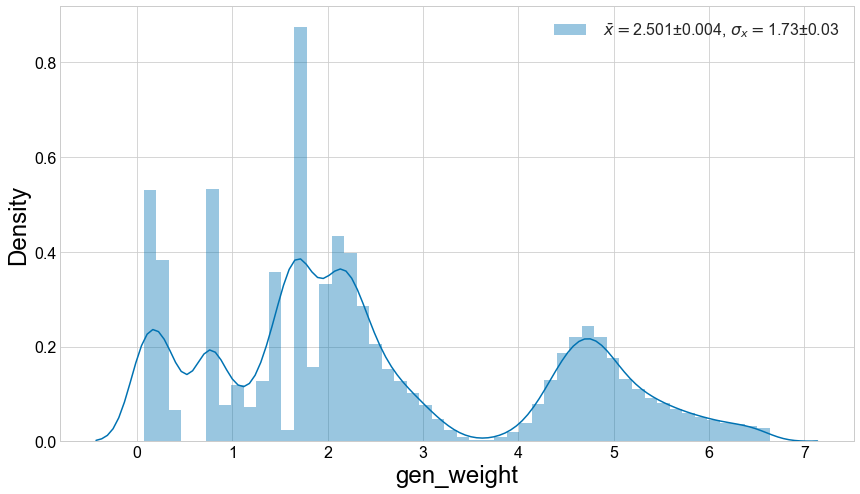

In [104]:
from lumin.plotting.data_viewing import plot_feat
plot_feat(df[df.gen_target==0], 'gen_weight')

Well, there are _basically_ three clusters there. Enough to work for this example, anyway. Lets cluster using _k_-means:

In [105]:
from sklearn.cluster import k_means
cluster = k_means(train_df.loc[train_df.gen_target == 0, 'gen_weight'].values[:,None], 3)
train_df.loc[train_df.gen_target == 0, 'gen_sample'] = cluster[1]
train_df.loc[train_df.gen_target == 1, 'gen_sample'] = 3
val_df.loc[val_df.gen_target == 0, 'gen_sample'] = abs(val_df.loc[val_df.gen_target == 0, 'gen_weight'][None,:]-cluster[0][:,None]).argmin(axis=0)[0]
val_df.loc[val_df.gen_target == 1, 'gen_sample'] = 3

Lets check some of the features. `plot_feat` is a flexible function to provide indicative information about the 1D distribution of a feature. By default it will produce a weighted KDE+histogram for the [1,99] percentile of the data, as well as compute the mean and standard deviation of the data in this region. By passing a list of cuts and labels, it will plot multiple distributions of the same feature for different cuts. Since it is designed to provide quick, indicative information, more specific functions (such as `plot_kdes_from_bs`) should be used to provide final results.

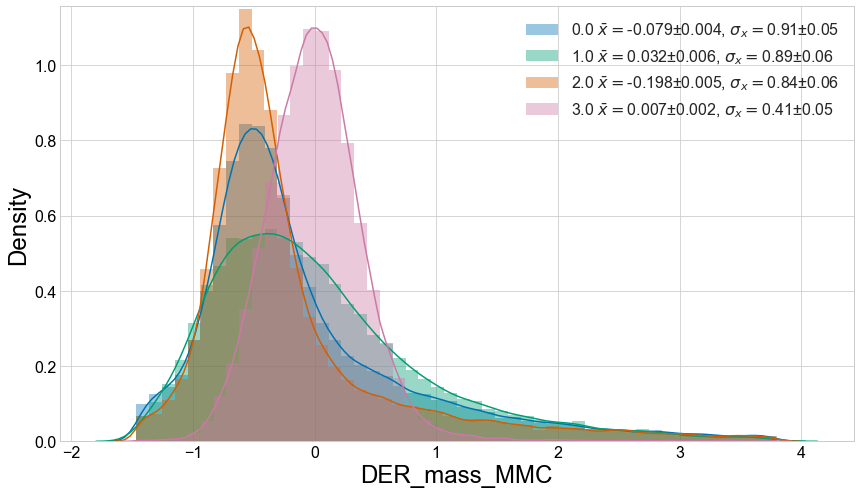

In [106]:
from lumin.plotting.data_viewing import plot_feat
plot_feat(train_df, 'DER_mass_MMC', cuts=[(train_df.gen_sample==s) for s in sorted(set(train_df.gen_sample))],
          labels=[str(s) for s in sorted(set(train_df.gen_sample))], moments=True)


### Weight processing
The data contains weights which are important to consider as they indicate which events are the most important to consider and are necessary to correctly compute the AMS at the end. However the data also contains an imbalance between the classes in terms of raw event numbers. We can correct for this imbalance by renormalising the weights such that the sum for each class is equal, however since we might also want to compute the AMS on the training data, we'll make a copy of the column first.

In [123]:
train_df['gen_orig_weight'] = train_df['gen_weight']
for s in set(train_df.gen_sample):
    train_df.loc[train_df.gen_sample == s, 'gen_weight'] /= np.sum(train_df.loc[train_df.gen_sample == s, 'gen_weight'])
train_df.gen_weight.sum()

4.000000000000001

### Conversion to fold file 

Having finished processing the data, we can now save it to h5py files in a format that `FoldYielder` will expect.

In [124]:
targ_feat = 'gen_sample'

In [125]:
from lumin.data_processing.file_proc import df2foldfile
df2foldfile(df=train_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats=targ_feat,
            weight_feat=weight_feat, misc_feats=misc_feats+['gen_orig_weight', 'gen_target'],
            savename=PATH/'train', targ_type='float32', strat_key='gen_strat_key')

Saving fold: 0 with 20003 events
Saving fold: 1 with 20003 events
Saving fold: 2 with 20003 events
Saving fold: 3 with 20003 events
Saving fold: 4 with 20002 events
Saving fold: 5 with 20001 events
Saving fold: 6 with 19999 events
Saving fold: 7 with 19996 events
Saving fold: 8 with 19995 events
Saving fold: 9 with 19995 events


In [126]:
df2foldfile(df=val_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats=targ_feat,
            weight_feat=weight_feat, misc_feats=misc_feats+['gen_target'],
            savename=PATH/'val', targ_type='float32', strat_key='gen_strat_key')

Saving fold: 0 with 5003 events
Saving fold: 1 with 5003 events
Saving fold: 2 with 5002 events
Saving fold: 3 with 5002 events
Saving fold: 4 with 5001 events
Saving fold: 5 with 5001 events
Saving fold: 6 with 5000 events
Saving fold: 7 with 4997 events
Saving fold: 8 with 4996 events
Saving fold: 9 with 4995 events


## Feature selection

Currently we're using all of the available information from the CSV file, however it contains an awful lot of high-level features which may not be useful for the regression. We can run a few checks to try and filter out the uneeded features.

`FoldYielder` is the base class we'll use to pull data from the h5py file. We can also recover the original dataframe via `get_df`, and deporcess it my adding the input pipe.

In [51]:
from lumin.nn.data.fold_yielder import FoldYielder
train_fy = FoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.add_input_pipe(input_pipe)
train_df = train_fy.get_df(inc_inputs=True, deprocess=True); train_df.head()

200000 candidates loaded


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_jet_subleading_px,PRI_jet_subleading_py,PRI_jet_subleading_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,127.389000,21.226999,91.297997,55.471001,0.000,0.000000,0.000,2.486,6.367001,127.245003,...,35.988003,-39.907848,-27.699987,0.000000,0.000000,0.000000,7.294997,1.0,3.0,0.000005
1,106.091003,17.892000,54.500999,139.080002,4.242,465.595001,-4.433,1.540,28.733000,225.096008,...,44.102974,-86.437813,-306.365417,-14.038713,-29.497673,174.087753,75.433998,3.0,3.0,0.000003
2,0.000000,145.454010,74.364998,73.465004,0.000,0.000000,0.000,2.587,3.759000,147.977005,...,-44.585278,-53.669586,133.922623,0.000000,0.000000,0.000000,106.498001,1.0,2.0,0.000051
3,137.731995,0.532997,96.319000,38.816998,0.000,0.000000,0.000,3.126,1.612001,118.365005,...,23.695385,32.649742,149.070587,0.000000,0.000000,0.000000,21.074999,1.0,3.0,0.000034
4,169.604004,37.951000,103.615997,59.974998,7.082,1425.665894,-12.071,2.982,23.367001,169.279999,...,-3.029964,-55.844860,485.216461,-19.626839,23.339497,-1042.317261,36.258999,2.0,3.0,0.000003


A first step can be to check for duplication of information via similar features. `plot_dendrogram` uses Spearman's rank correlation and hierarchical clustering to group features by similarity. From right to left, features which are combined closer to the left are more similar, and it is worth checking whether one of a pair of features which are combined straight away can be safely removed (**N.B.** one of the features of a close clustering has to remain to otherwise the information of the pair is lost).

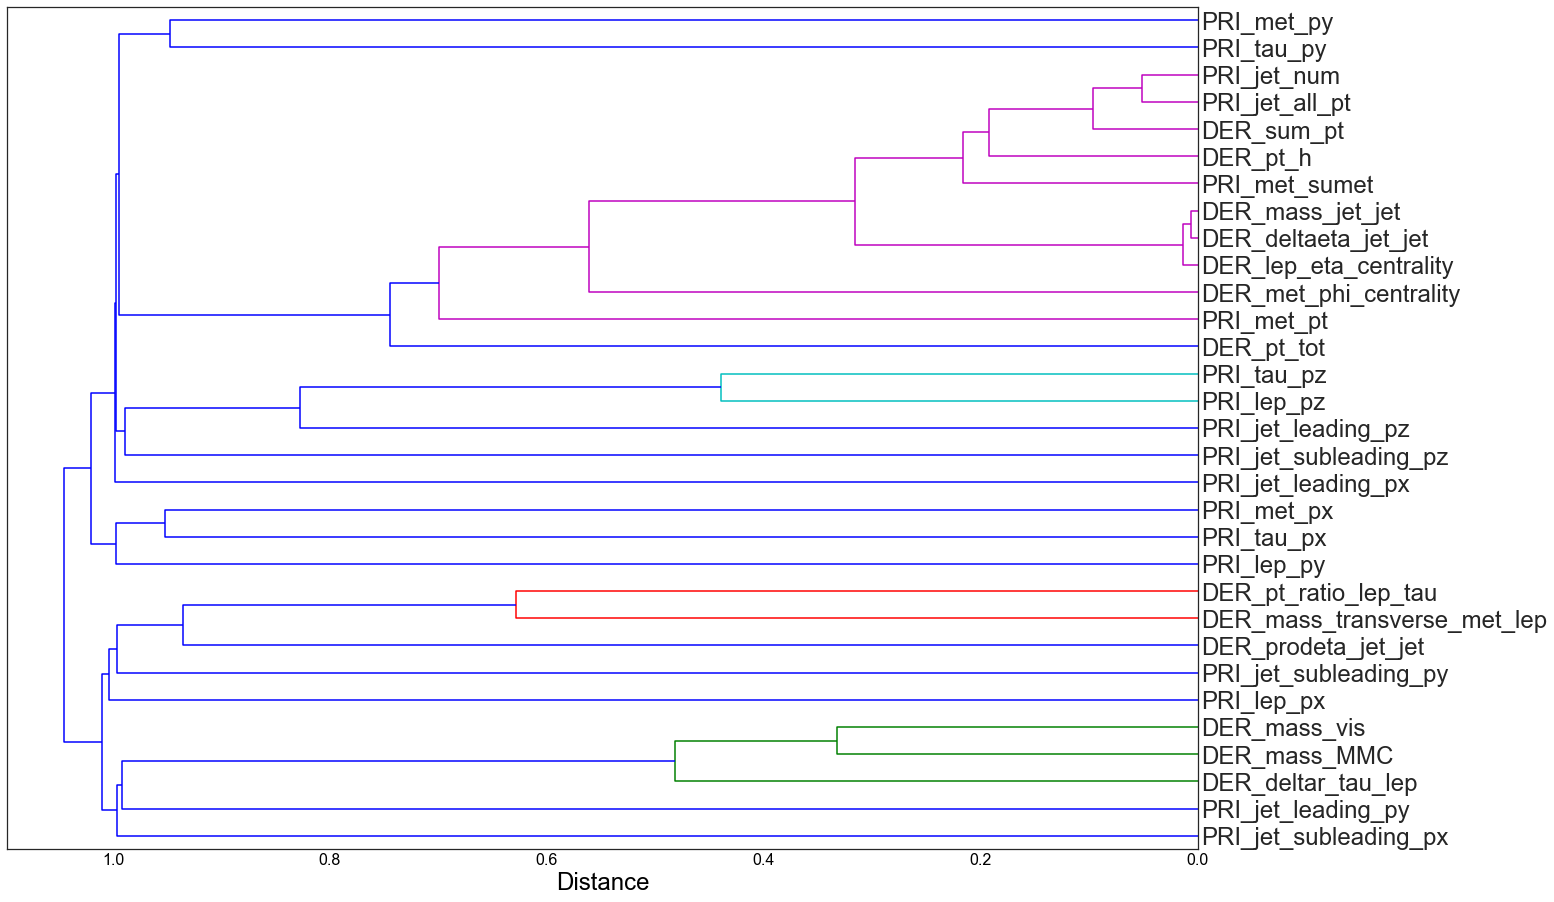

In [52]:
from lumin.plotting.data_viewing import plot_dendrogram
plot_dendrogram(train_df[train_feats])

None of the features get clustered straight away (but the di-jet mass and $\Delta\eta$ features are borderline), so each feature contains at least some unique information. For further tests we'll want to split of another, temporary validation set

In [53]:
df_trn, df_val = train_test_split(train_df, test_size=0.8)

We're mainly interested in filtering down the high-level features, and will assume that the random forests we'll be using will not be able to make as much use of the lower level information as the neural networks will, so we'll only test the high level features and add regularisation as necessary later.

In [54]:
vec_feats = []
for c in ['px', 'py', 'pz', 'mass']:
    vec_feats += [f for f in train_feats if f == f'{f[:f.rfind("_")+1]}{c}']
len(vec_feats)

14

In [55]:
hl_feats = [f for f in train_feats if f not in vec_feats]; len(hl_feats)

17

Let's see which of the high-level features the RFs find useful. `rf_rank_features` wraps rfpimp and initially trains a RF using the data and eveluates it on the validation set. It then sequentially makes a copy of the data and randomises the order of one of the fetaures and then reevaluates the model performance, and compares it to the original score. If their is a large decrease in the score, then the feature which was randomised was very important in the model. If there is only a small decrease (or increase) in the score, then the feature was not important.

Having established the importance of the features, `rf_rank_features` then runs another training only using the features with importances higher the the `cut` argument. If there is no decrease in the score, the ignored features can probably be safely removed.

Optimising RF


Top ten most important features:
                        Feature  Importance
0                 DER_mass_MMC      0.0848
1  DER_mass_transverse_met_lep      0.0484
2                     DER_pt_h      0.0232
3                   DER_pt_tot      0.0218
4               PRI_jet_all_pt      0.0212
5                 DER_mass_vis      0.0142
6       DER_met_phi_centrality      0.0132
7                   DER_sum_pt      0.0122
8                  PRI_jet_num      0.0116
9                   PRI_met_pt      0.0100


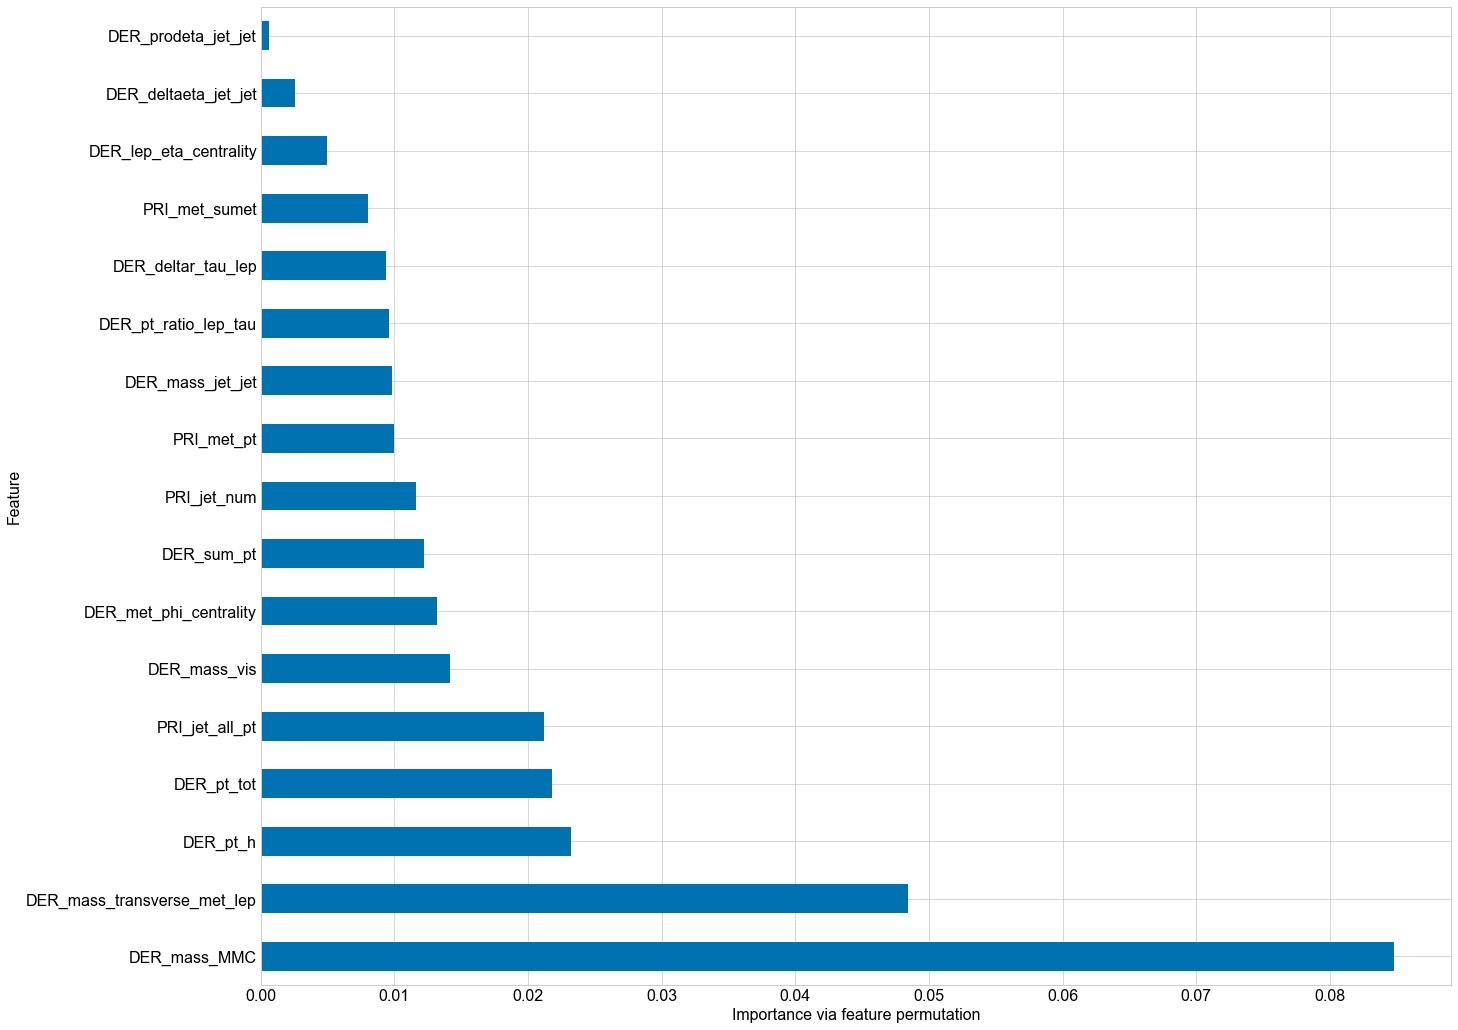


16 features found with importance greater than 0.001:
 ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_pt_h', 'DER_pt_tot', 'PRI_jet_all_pt', 'DER_mass_vis', 'DER_met_phi_centrality', 'DER_sum_pt', 'PRI_jet_num', 'PRI_met_pt', 'DER_mass_jet_jet', 'DER_pt_ratio_lep_tau', 'DER_deltar_tau_lep', 'PRI_met_sumet', 'DER_lep_eta_centrality', 'DER_deltaeta_jet_jet']

Optimising new RF


Comparing RF scores, higher = better
All features:	0.68799
Top features:	0.68895


In [56]:
from lumin.optimisation.features import rf_rank_features
import_feats = rf_rank_features(df_trn, df_val, objective='classification', train_feats=hl_feats, cut=0.001)

So, it seems that most of the high-level features are providing some information, and it's reassuring to see that the MMC mass (estimate of the Higgs mass) was found to be the most important HL feature. However, the above method of permutation importance, does not account for the possibility of sets of features being correlated; features carrying mutual information can lead to them being assigned low importances since when one feature is randomised, the other makes up for it and performance remains the same. In reality we'd only want to remove one of these features, since removing both could lead to a drop in performance. `rfpimp` provides some useful functions for plotting the correlations between features, and to check feature dependence by seeing how easily random forests are able to regress to each input feature in turn using the other features as inputs.

In [57]:
from rfpimp import plot_corr_heatmap, feature_dependence_matrix, plot_dependence_heatmap

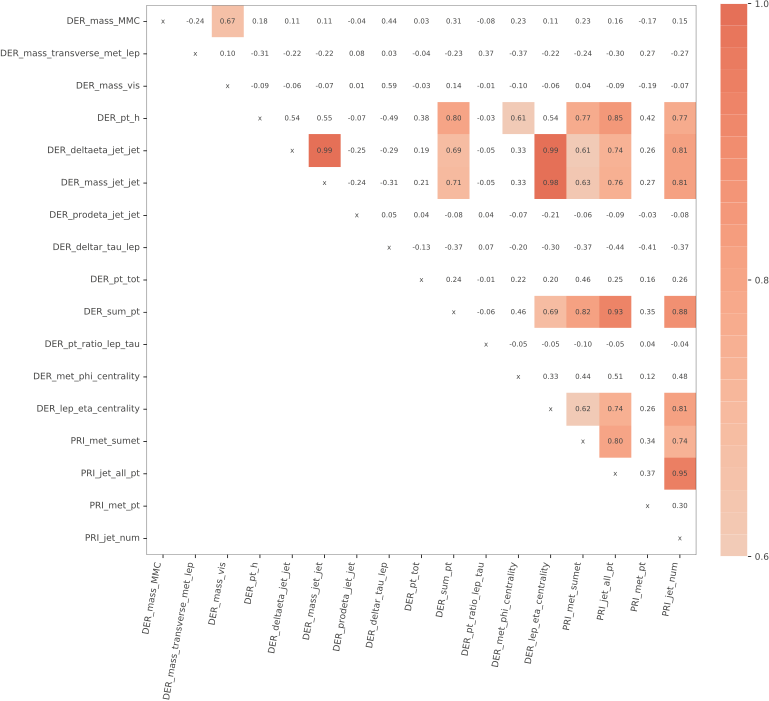

In [58]:
plot_corr_heatmap(df_trn[hl_feats], figsize=(11,11), label_fontsize=9, value_fontsize=7)

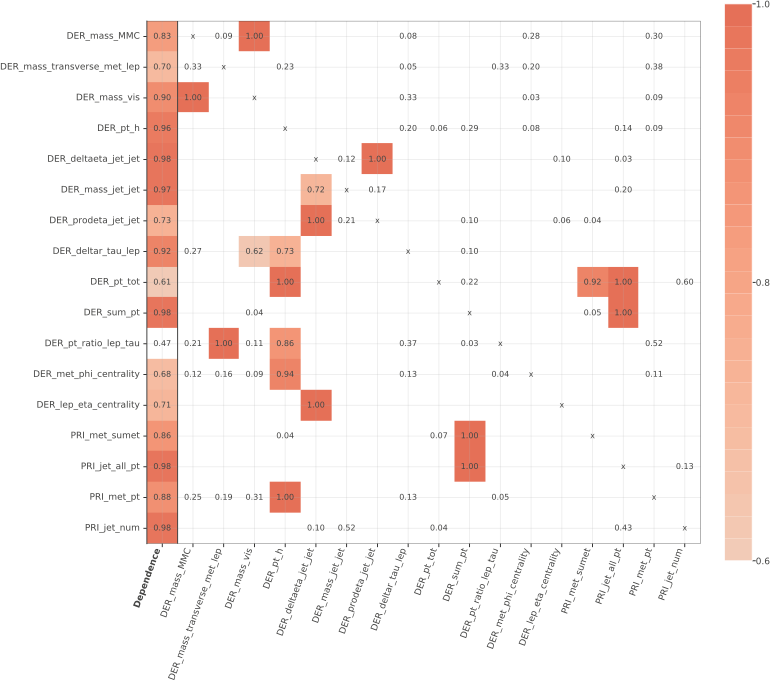

In [59]:
from sklearn.ensemble import RandomForestRegressor
D = feature_dependence_matrix(df_trn[hl_feats], sort_by_dependence=False, rfmodel=RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True))
plot_dependence_heatmap(D, figsize=(11,10))

The first column 'Dependence' indicates how well a feature can be predicted using the other features (higher dependence = more easily predictable). The other columns indicate the relative importance of the features in predicting that feature.

We can see that non of the features are completely predictable but there are several close ones. We'll just use all of them and a regularisation if necessary.

In [60]:
with open(PATH/'feats.pkl', 'wb') as fout:
    pickle.dump({'targ_feats': targ_feat, 'cont_feats': cont_feats, 'cat_feats': cat_feats, 'cat_maps': cat_maps, 'cat_szs': cat_szs}, fout)

## Train classifier

Now we're ready to begin training the network-based classifier. First we can load the feature sets, create a `FoldYielder` for the training data.

In [3]:
with open(PATH/'feats.pkl', 'rb') as fin:
    feats = pickle.load(fin)
    targ_feats = feats['targ_feats']
    cont_feats = feats['cont_feats']
    cat_feats = feats['cat_feats']    
    cat_maps = feats['cat_maps']    
    cat_szs = feats['cat_szs']
    train_feats = cont_feats + cat_feats
    
with open(PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

### Data augmentation
We'll load the data using a specialised `FoldYielder` designed to provide the event rotations we want.

In [4]:
from lumin.nn.data.fold_yielder import HEPAugFoldYielder
train_fy = HEPAugFoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats, rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


During training, this will randomly rotate the event in phi, randomly flip it in the y-axis, and randomly flip it in the z-axis. Lets view a few possible examples of the same event.

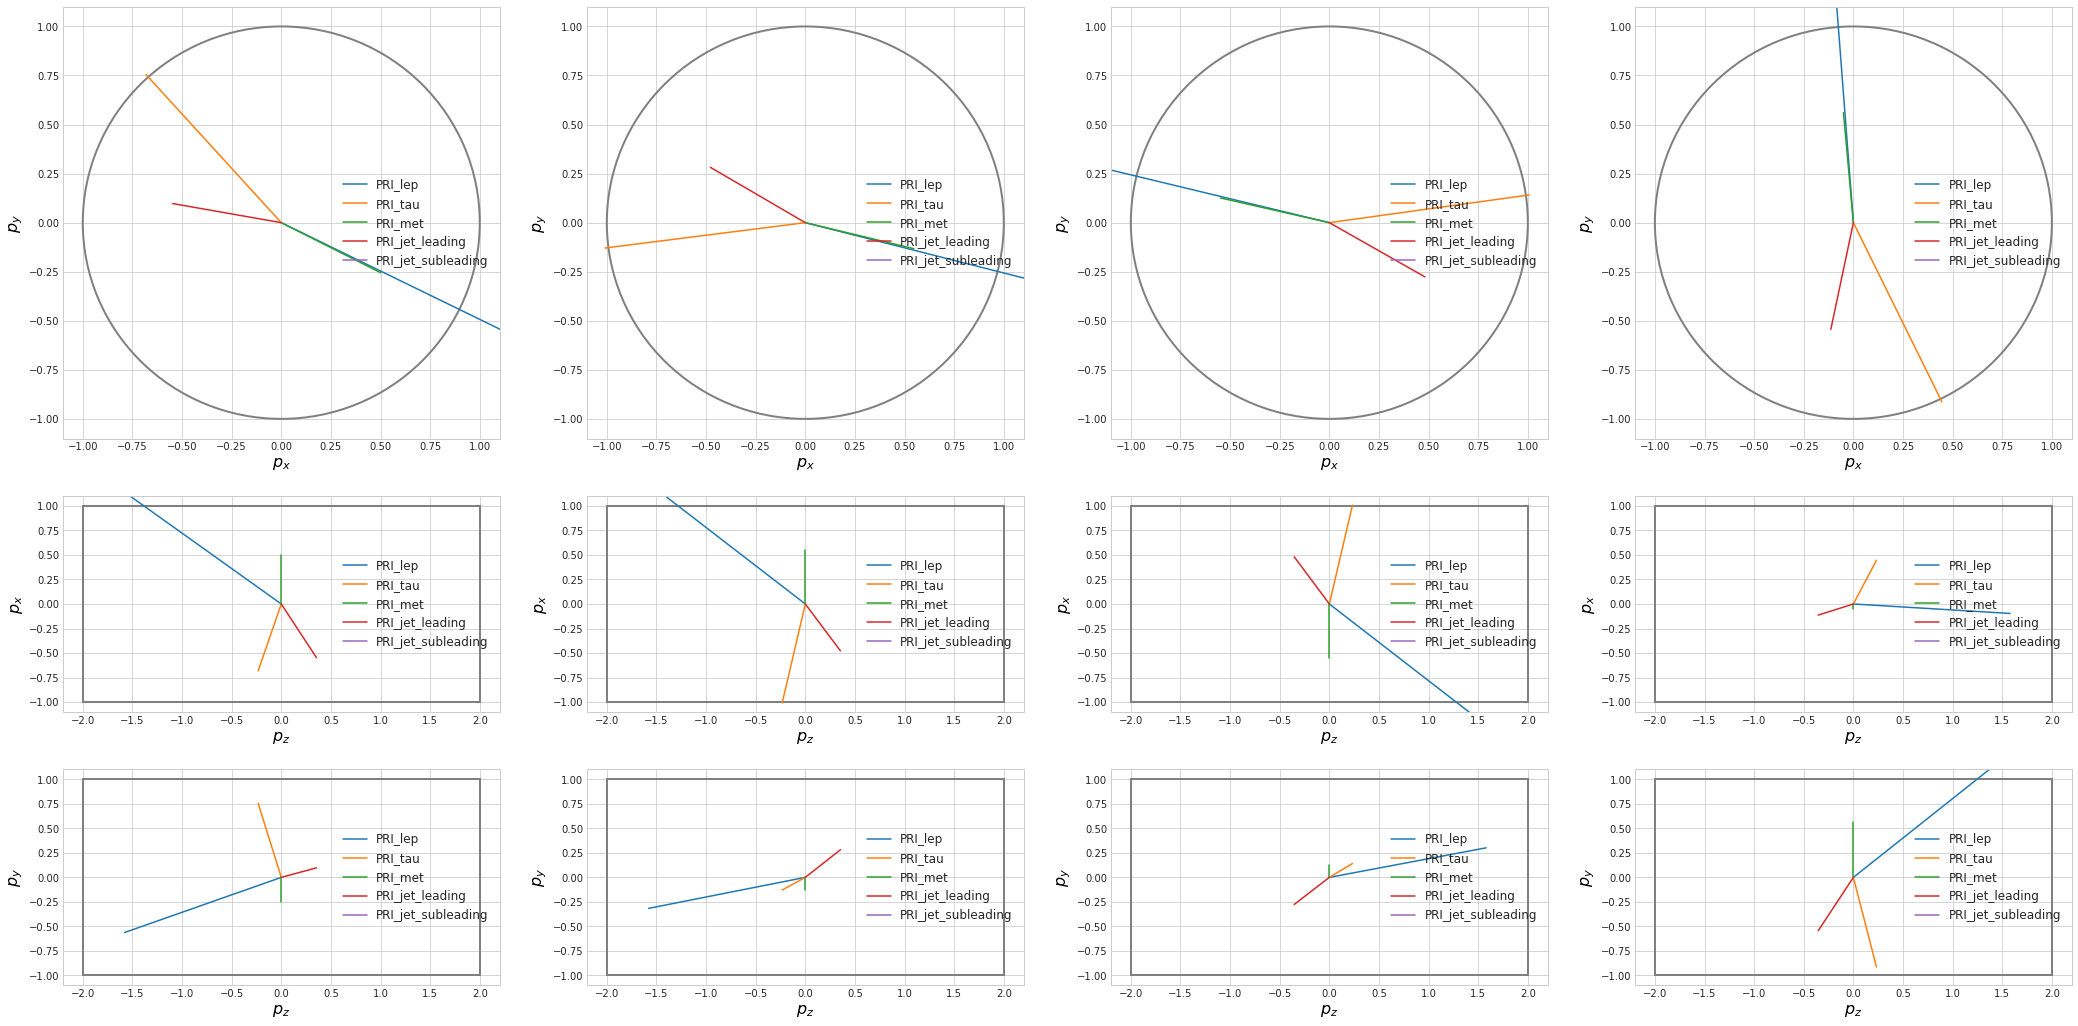

In [63]:
from lumin.plotting.data_viewing import compare_events
idx=3
compare_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[idx:idx+1] for i in range(4)])

During testing it will provide versions of each possible combination of flips for 2 set rotations.

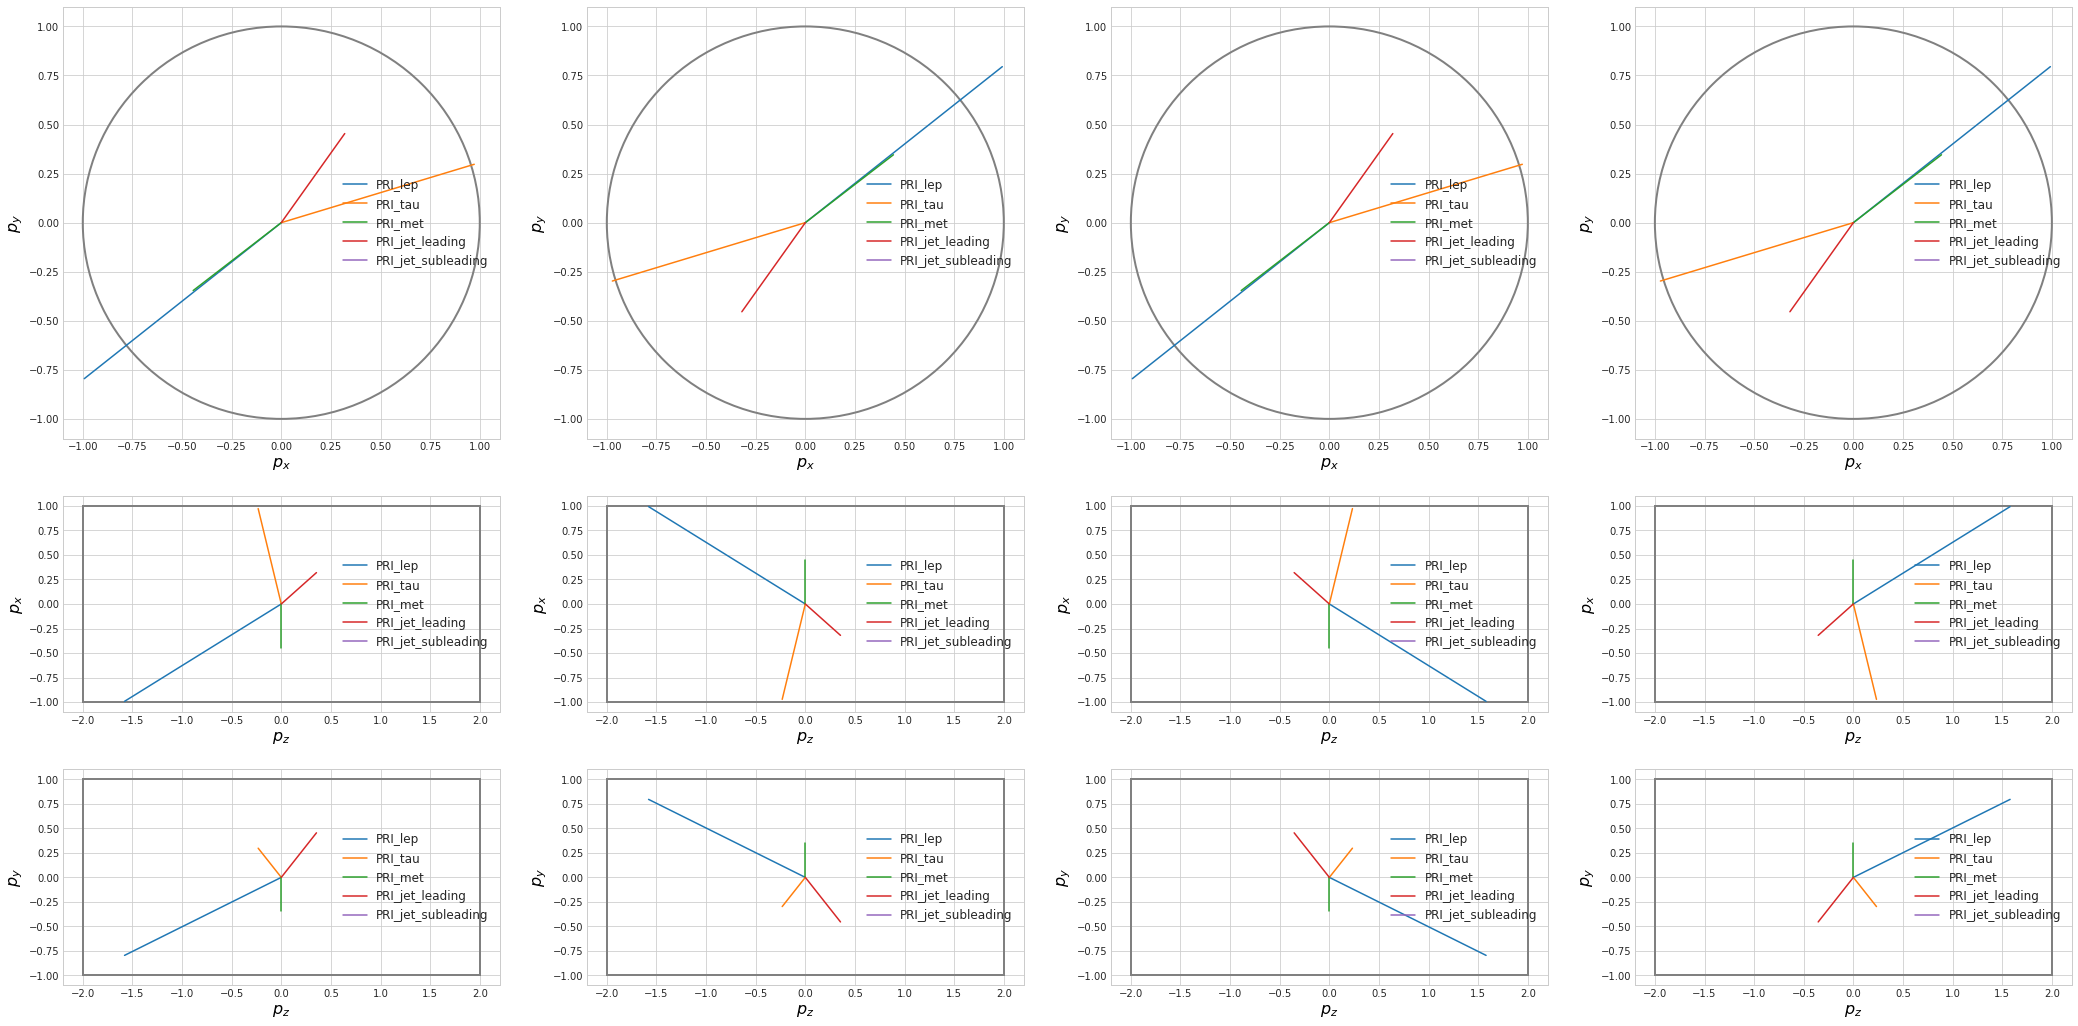

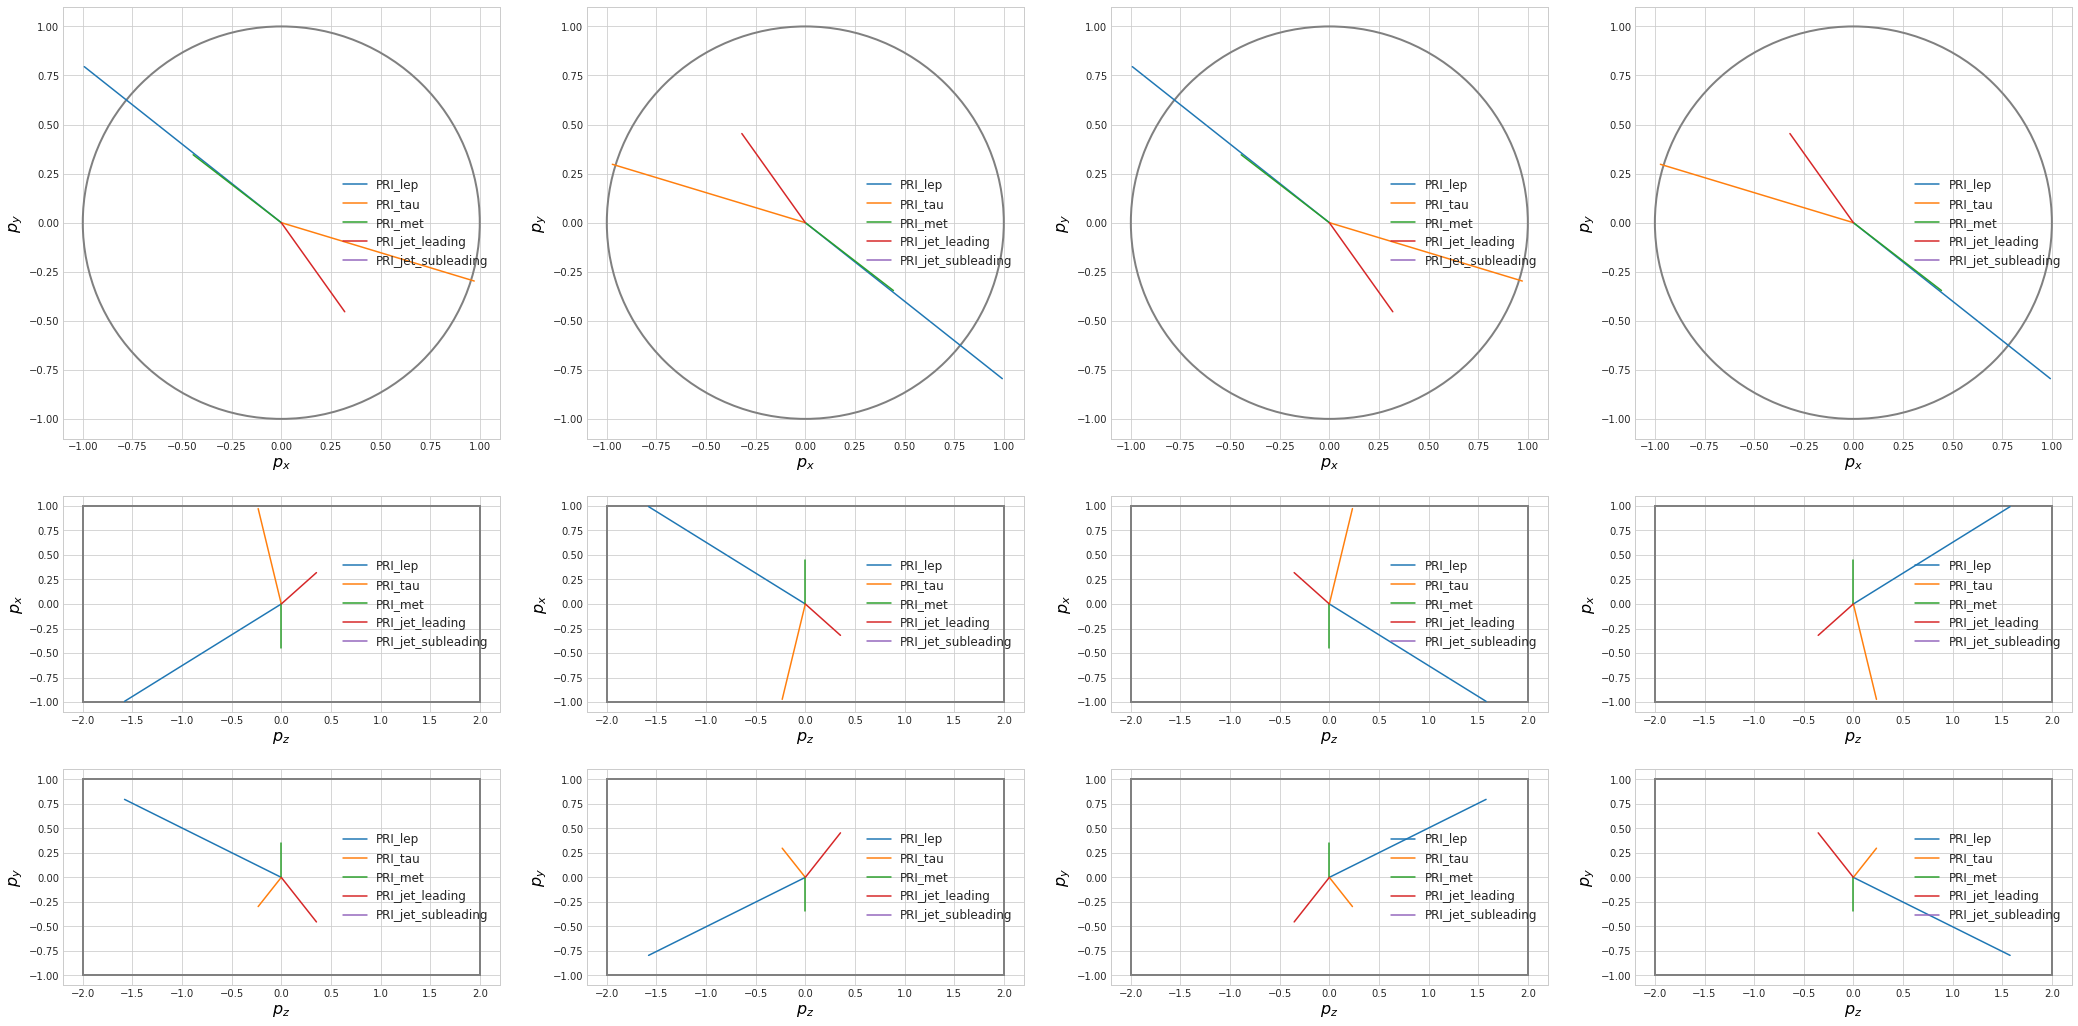

In [64]:
for aug_range in [range(4), range(4,8)]:
    compare_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[idx:idx+1] for i in aug_range])

### Training
Here we define the architecture of the models, and how we want to train them. `ModelBuilder` takes arguments to define the network, loss, optimiser, and inputs and outputs and can then create networks on demand. These networks are provided as properties of the `Model` class which contains methods to train them, evaluate, predict, save/load, et cetera.
#### ModelBuilder
Most of the parameters will use default values if not provided explicitly which can be viewed in the source code, e.g. `ModelBuilder.parse_cat_args`, `ModelBuilder.parse_loss`, `ModelBuilder.parse_model_args`, and `ModelBuilder.parse_opt_args`.
##### Architecture
The network consists of three parts: A head, which takes the inputs to the network; a body, which contains the majority of the hidden layers; and a tail which downscales the output of the body to match the desired number of outputs. The classes used for each can be specified 

By default the head is `CatEmbHead` which provides [entity embeddings](https://arxiv.org/abs/1604.06737) for categorical features (embedding sizes can be configured manually, or left as default `max(50,cardinality//2)`), and then a batch normalisation with the continuous inputs, with separate dropouts for embeddings and continuous inputs. These are then fed into a dense layer to scale up the connections to the model width parameter. More advanced classes, can be passed to the `ModelBuilder` head argument, or `ModelBuilder.get_head` overridden in an inheriting class.

The default body is a simple sequence of hidden layers (`FullyConnected`). These layers can optionally have dropout, batch normalisation, skip connections (residual network), or cumulative concatenations (dense network). The choice of class is set by `ModelBuldier`'s `body` argument, and built by `ModelBuilder.get_body`.

The tail (default `ClassRegMulti` set by `tail` argument/`ModelBuilder.get_tail`) uses a final dense layer to scale down the body output to match `n_out` and then applies an automatically selected activation according to `objective`:
- 'class*' or 'labelclass*' = sigmoid
- 'multiclass' = logsoftmax
- 'regression' and not `y_range` = linear
- 'regression' and `y_range` = sigmoid + offset and rescaling
##### Loss
This can either be passed as the `loss` argument of `ModelBuilder`, or be left to be automatically chosen according to `objective`:
- 'class*' or 'labelclass*' = Binary cross-entropy (`nn.BCELoss`)
- 'multiclass' = Weighted cross-entropy (`WeightedCCE`)
- 'regression' = Weighted mean-squared error (`WeightedMSE`, (`WeightedMAE` also exists but must be explicitly passed))

**N.B.** If a loss class is passed explicitly, it should be uninitialised to allow weights to be correctly handled.

`ModelBuilder.parse_loss` handles the automatic loss configuration.
##### Optimiser
Configured by `opt_args` argument of `ModelBuilder`, `ModelBuidler.parse_opt_args`, and `ModelBuilder.build_opt`. Currently only SGD and Adam are available. Choices of weight decay should be added in `opt_args`. The Learning rate can be set later via `ModelBuilder.set_lr`.

#### Architecture
For our example architecture we'll use SELU-based 4-layer network of width 100. We'll also load in the embedding weights for the jet multiplicity which were learnt during the binary classification example (`'emb_load_path':Path('weights')` in `cat_args`).

In [38]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
import torch.nn as nn

bs = 256
objective = 'multiclass_classifier'
model_args = {'act':'selu', 'width':100, 'depth':4}
opt_args = {'opt':'adam', 'eps':1e-08}
n_cont_in=len(cont_feats)
cat_args = {'n_cat_in':len(cat_feats), 'cat_szs':[cat_szs[f] for f in cat_szs],
            'cat_names':[f for f in cat_szs], 'emb_szs':None, 'emb_load_path':Path('weights')}

n_out = 4
model_builder = ModelBuilder(objective, n_cont_in=len(cont_feats), n_out=n_out, cat_args=cat_args,
                             model_args=model_args, opt_args=opt_args)

print("\nTraining on", len(cont_feats), " continuous features:", [var for var in cont_feats])
print("\nTraining on", len(cat_feats), " categorical features:", [var for var in cat_feats])
print('\n Model:')
print(Model(model_builder))


Training on 30  continuous features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_pt']

Training on 1  categorical features: ['PRI_jet_num']

 Model:
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Model:
<bound method Module.parameters of Sequential(
  (0): Sequential(
    (0): CatEmbHead(
      (embeds): ModuleList(
        (0): Embedding(4, 3)
      )
      (bn): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
 

The learning rate can be quickly optimised via the [LR range test](https://arxiv.org/abs/1506.01186). This involves gradually increasing the LR from a small value to a lrage one after each minibatch update and then plotting the loss as a function of the LR. One can expect to see an initial period of slow, or nonexistant, loss decrease where the LR is far too small. Eventully the LR becomes large enough to allow useful weigh updates (loss decreases). Eventually the LR becomes so large the network diverges (loss platues then increases). The optimal LR is the highest one at which the loss is still decreasing.

To allow for the randomness between different network trainings and data, `fold_lr_find`, runs several trainings using different folds of the data and then plots to mean and standard deviation of the loss.

Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
LR finder took 3.674s 


/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


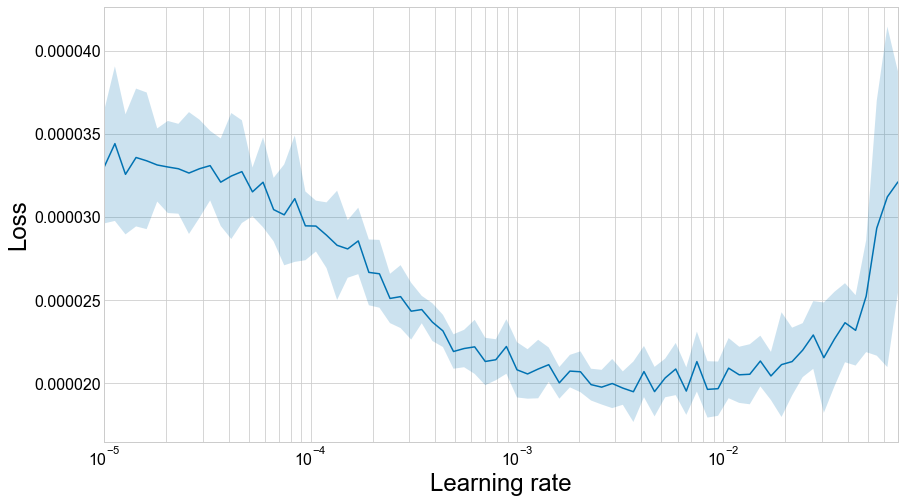

In [39]:
from lumin.optimisation.hyper_param import fold_lr_find
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e-1], train_on_weights=True)

Looks like somewhere around 8e-4 should be good.

The training function takes several sets of callbacks, ways to alter the model's training schedule, to report more specialised results, to affect the earlystopping, and to keep track of model weights.

For this example we'll train an ensemble of 5 models trained using [SGD with warm-restarts](https://arxiv.org/abs/1608.03983) following a cosine-annealed learning rate with a cycle multiplicity of 2.

We'll also add an evaluation metric to compute the AMS on the validation folds. However, since the classifier is predicting the sample each event belongs to, we need to condense the output back to a binary prediction. Note that we tell the AMS calculation to load the original weights, and tell it the total number of events in the sample. This allows the weights to be rescaled to account for the fact that the AMS will be calculated only on the validation folds, which are much smaller than the full training sample. `br=10` is a factor included in the HiggsML competition.

In [42]:
from lumin.nn.callbacks.cyclic_callbacks import CycleLR
from lumin.nn.metrics.class_eval import MultiAMS

n_models = 5
patience = 2
max_epochs = 50

use_callbacks = [{'callback':CycleLR, 'kargs':{'lr_range': (0, 8e-4), 'cycle_mult':2}}]
eval_metrics = {'MultiAMS':MultiAMS(n_total=250000, br=10,
                                    zero_preds=['pred_0', 'pred_1', 'pred_2'], one_preds=['pred_3'],
                                    targ_name='gen_target', weight_name='gen_orig_weight')}
plots = ['history']

`fold_train_ensemble` performs training of (an ensemble of) models produced by the `ModelBuilder` using data provided by a `FoldYielder`. Model training  runs for upto `max_epochs` number of epochs, or until `patience` number of sub-epochs (or cycles) have elapsed with out an improvment of the validation loss. The model is then saved to `saveloc` to be loaded later. The function returns results of the training and model perfomance on validation fold. If an `AbsCyclicCallback` is used, then snapshots of the model weights are automatically saved after each cycle to allow for [Snapshot Ensembling](https://arxiv.org/abs/1704.00109) or [Fast Geometric Ensembling](https://arxiv.org/abs/1802.10026).

Training model 1 / 5
Loading embedings: {0: 'weights/PRI_jet_num.h5'}


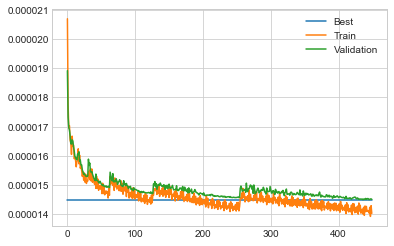

Scores are: {'loss': 1.4484146959148347e-05, 'MultiAMS': 2.1772105974386964}
Fold took 189.854s

Training model 2 / 5
Loading embedings: {0: 'weights/PRI_jet_num.h5'}


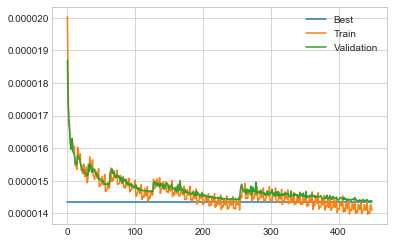

Scores are: {'loss': 1.4360039131133817e-05, 'MultiAMS': 2.14570994729314}
Fold took 188.502s

Training model 3 / 5
Loading embedings: {0: 'weights/PRI_jet_num.h5'}


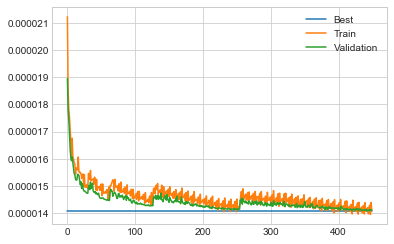

Scores are: {'loss': 1.407915806339588e-05, 'MultiAMS': 2.156271525176341}
Fold took 187.646s

Training model 4 / 5
Loading embedings: {0: 'weights/PRI_jet_num.h5'}


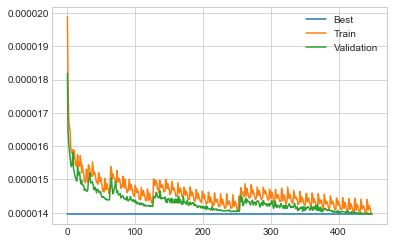

Scores are: {'loss': 1.394872469973052e-05, 'MultiAMS': 2.1637500930010805}
Fold took 187.671s

Training model 5 / 5
Loading embedings: {0: 'weights/PRI_jet_num.h5'}


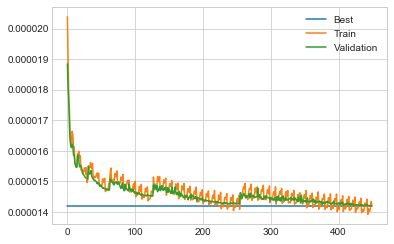

Scores are: {'loss': 1.4197310520103201e-05, 'MultiAMS': 2.169505975641002}
Fold took 191.373s


______________________________________
Training finished
Cross-validation took 945.051s 


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

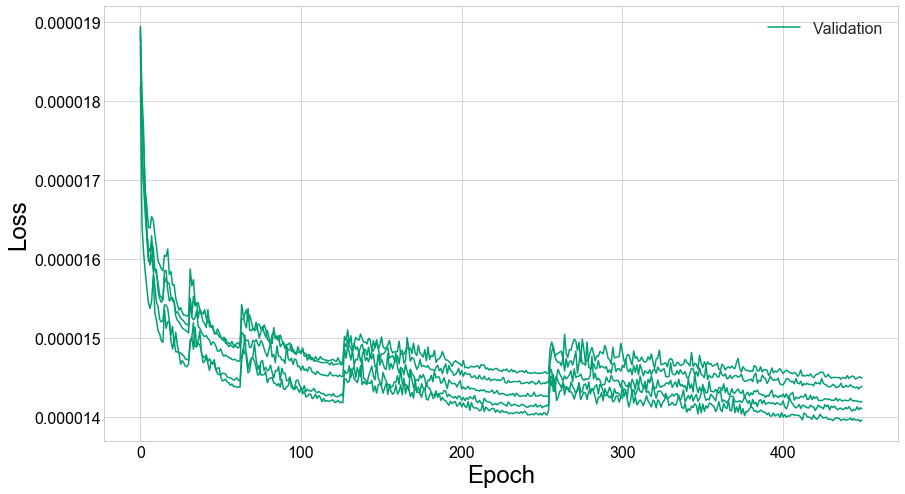

Mean loss = 1.421e-05±9e-08
Mean MultiAMS = 2.162±0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [43]:
from lumin.nn.training.fold_train import fold_train_ensemble
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs, train_on_weights=True,
                                                       use_callbacks=use_callbacks,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience,
                                                       plots=plots)

## Ensemble loading
We can now build an ensemble from the trained models, however rather than simply treating them all equally, we can weight them according to some metric (e.g. AMS, reciprocal of loss).

In [44]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [48]:
model_builder.emb_load_path = None

In [49]:
from lumin.nn.ensemble.ensemble import Ensemble
ensemble = Ensemble()
ensemble.build_ensemble(results, 5, model_builder, metric='loss')

Choosing ensemble by loss


Model 0 is 3 with loss = 1.394872469973052e-05
Model 1 is 2 with loss = 1.407915806339588e-05
Model 2 is 4 with loss = 1.4197310520103201e-05
Model 3 is 1 with loss = 1.4360039131133817e-05
Model 4 is 0 with loss = 1.4484146959148347e-05


The default location is likely to be overwritten, so we can save it to a more permanent location.

In [50]:
name = 'weights/Multiclass_Classification'
ensemble.save(name, feats=train_feats, overwrite=True)

## Validation without TTA
Now we can test how well our ensemble performs on our validation set. We'll run first without test-time data augmentation (TTA).

In [82]:
from lumin.nn.ensemble.ensemble import Ensemble
ensemble = Ensemble()
ensemble.load('weights/Multiclass_Classification')

In [83]:
from lumin.nn.data.fold_yielder import FoldYielder
val_fy = FoldYielder(h5py.File(PATH/'val.hdf5', "r+"), cont_feats, cat_feats)

In [84]:
ensemble.predict(val_fy)

Mean time per event = 1.6719E-06±4.3879E-08


Remember we need to load the original class for the target, rather than the sample. We can then use `to_binary_class` to map the sample predictions to signal and background:
- sample = argmax pred_*
- pred = pred if sample == signal else 1-pred

In [60]:
from lumin.utils.misc import to_binary_class
val_df = val_fy.get_df(targ_name='gen_target')
to_binary_class(val_df, ['pred_0', 'pred_1', 'pred_2'], ['pred_3']); val_df.head()

50000 candidates loaded


,gen_target,gen_weight,pred_0,pred_1,pred_2,pred_3,pred
0,1,0.002653,0.289378,0.037678,0.096700,0.576245,0.576245
1,0,1.373391,0.238416,0.001196,0.649585,0.110804,0.350415
2,0,5.244745,0.117373,0.748293,0.001477,0.132857,0.251707
3,0,1.681611,0.777653,0.001913,0.085117,0.135317,0.222347
4,1,0.001503,0.100856,0.000211,0.171965,0.726968,0.726968


In the HiggsML challenge, prediction on the test set requires specifying whether each event is signal or background, meaning we need to apply a cut on our class prediction. We could simply scan across the events in the validation sample and see where the AMS is maximised, (not we apply a weight factor to account for the difference between our validation sample and the full training sample):

In [61]:
from lumin.evaluation.ams import ams_scan_slow
ams_scan_slow(val_df, br=10, w_factor=250000/50000, start_cut=0.9)

(3.20672573663043, 0.9000022)

A maximu AMS of 3.207 ffor a cut of 0.900; not as good a result as we had for the binary classification version, but it's still an interesting approach and this only meant to be an example of multiclass classification anyway.

The maximum AMS is a tricky metric that can easily be affected by statistical fluctuations due to limited data. It is extremely likely that event though we are getting this result on unseen data, it will not generalise very well. Instead we want to try and capture the general trend of the AMS and place our cut in the approximate region of high performance, rather than picking exactly where the AMS happened to maximise on our data. I've experimented with numerous approaches (bootstrap resampling, cross-validation, KDEs, et cetera) and found that so far the most generalising method is to rank points by events by their AMS, and then take the mean prediction of the top 5% as the cut.

Mean cut at 0.9303566217422485 corresponds to AMS of 2.9921529571707572
Maximum AMS for data is 3.20672573663043 at cut of 0.9000021815299988


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


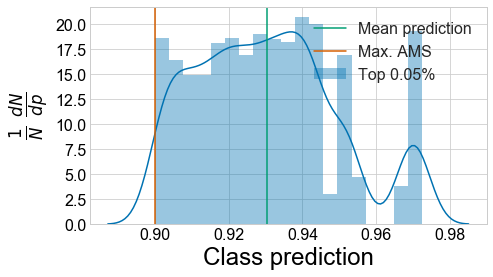

In [62]:
from lumin.optimisation.threshold import binary_class_cut
cut = binary_class_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

So, the AMS has dropped from 3.207 to 2.992, and interestingly the mean cut is higher than the max AMS cut.

## Validation with TTA
Now we'll see whether TTA can improve our result.

In [107]:
from lumin.nn.ensemble.ensemble import Ensemble
ensemble = Ensemble()
ensemble.load('weights/Multiclass_Classification')

In [108]:
from lumin.nn.data.fold_yielder import HEPAugFoldYielder
val_fy = HEPAugFoldYielder(h5py.File(PATH/'val.hdf5', "r+"), cont_feats, cat_feats, rot_mult=2, input_pipe=input_pipe)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


Note that prediction using `HEPAugFoldYielder` predicts each event 8 times, once on each augmented version, and takes the average. We'll also specify a name for the prediction to saved under to avoid overwriting the non-TTA predictions.

In [109]:
ensemble.predict(val_fy, pred_name=[f'pred_TTA_{i}' for i in range(4)])

Mean time per event = 7.6271E-05±4.3774E-07


In [110]:
val_df_tta = val_fy.get_df(pred_name=['pred_TTA_{i}' for i in range(4)], targ_name='gen_target')
to_binary_class(val_df_tta, [f'pred_{i}' for i in range(3)], ['pred_3']); val_df_tta.head()

50000 candidates loaded


,gen_target,gen_weight,pred_0,pred_1,pred_2,pred_3,pred
0,1,0.002653,0.276649,0.034099,0.097777,0.591475,0.591475
1,0,1.373391,0.231749,0.001115,0.660505,0.106631,0.339495
2,0,5.244745,0.117660,0.746562,0.001461,0.134317,0.253438
3,0,1.681611,0.776511,0.001936,0.085501,0.136052,0.223489
4,1,0.001503,0.094382,0.000227,0.171096,0.734295,0.734295


Mean cut at 0.9301738142967224 corresponds to AMS of 3.061565643609072
Maximum AMS for data is 3.1830227142969942 at cut of 0.9073750972747803


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


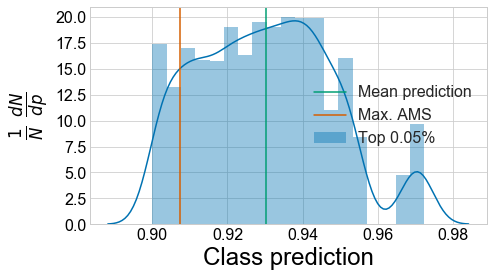

In [111]:
from lumin.optimisation.threshold import binary_class_cut
cut_tta = binary_class_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

An improved AMS at the mean cut of 3.062. We can also plot the prediction distribution:

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


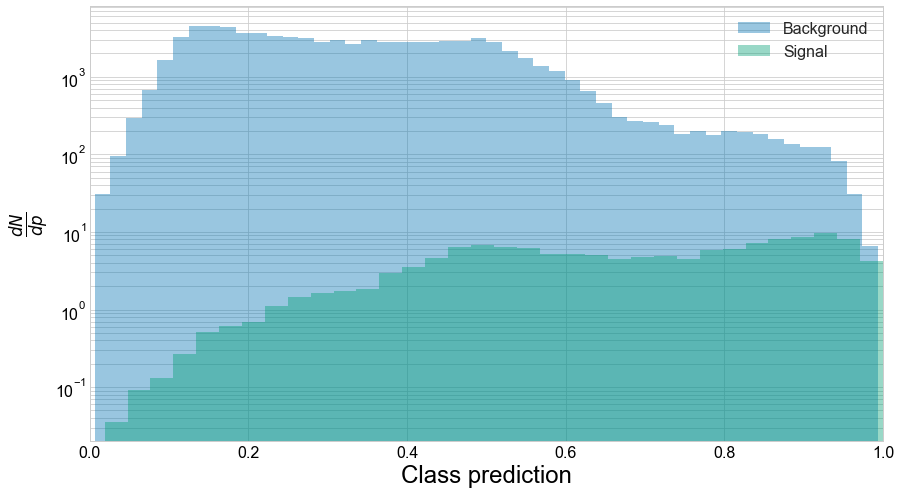

In [112]:
from lumin.plotting.results import plot_binary_class_pred
plot_binary_class_pred(val_df_tta, weight_name='gen_weight', density=False, log_y=True)

## Plotting
In a real HEP search, one might well wish to instead plot the discriminant split by sample. We'll load up the samples, rename them to something more meaningful (just guessing the order I'm afraid), and use `plot_sample_pred` to get a more flexible histogram.

In [125]:
val_df_tta['gen_sample'] = val_fy.get_column('targets'); val_df_tta.head()

,gen_target,gen_weight,pred_0,pred_1,pred_2,pred_3,pred,ams,gen_sample
0,1,0.002653,0.276649,0.034099,0.097777,0.591475,0.591475,-1.0,3.0
1,0,1.373391,0.231749,0.001115,0.660505,0.106631,0.339495,-1.0,0.0
2,0,5.244745,0.117660,0.746562,0.001461,0.134317,0.253438,-1.0,1.0
3,0,1.681611,0.776511,0.001936,0.085501,0.136052,0.223489,-1.0,0.0
4,1,0.001503,0.094382,0.000227,0.171096,0.734295,0.734295,-1.0,3.0


In [126]:
samples = [x[0] for x in np.array(sorted(zip(range(3), [val_df_tta.loc[val_df_tta['gen_sample']==y, 'gen_weight'].sum() for y in range(3)]), key=lambda x: x[1]))]
for i, s in enumerate(samples):
    if   i == 0: val_df_tta.loc[val_df_tta['gen_sample']==s, 'gen_sample'] = r'$W$-boson'
    elif i == 1: val_df_tta.loc[val_df_tta['gen_sample']==s, 'gen_sample'] = r'$Z\rightarrow\tau\bar{\tau}$'
    elif i == 2: val_df_tta.loc[val_df_tta['gen_sample']==s, 'gen_sample'] = r'$t\bar{t}$'
val_df_tta.loc[val_df_tta['gen_sample']==3, 'gen_sample'] = r'Signal: $H\rightarrow\tau\bar{\tau}$'
val_df_tta.head()

,gen_target,gen_weight,pred_0,pred_1,pred_2,pred_3,pred,ams,gen_sample
0,1,0.002653,0.276649,0.034099,0.097777,0.591475,0.591475,-1.0,Signal: $H\rightarrow\tau\bar{\tau}$
1,0,1.373391,0.231749,0.001115,0.660505,0.106631,0.339495,-1.0,$Z\rightarrow\tau\bar{\tau}$
2,0,5.244745,0.117660,0.746562,0.001461,0.134317,0.253438,-1.0,$t\bar{t}$
3,0,1.681611,0.776511,0.001936,0.085501,0.136052,0.223489,-1.0,$Z\rightarrow\tau\bar{\tau}$
4,1,0.001503,0.094382,0.000227,0.171096,0.734295,0.734295,-1.0,Signal: $H\rightarrow\tau\bar{\tau}$


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


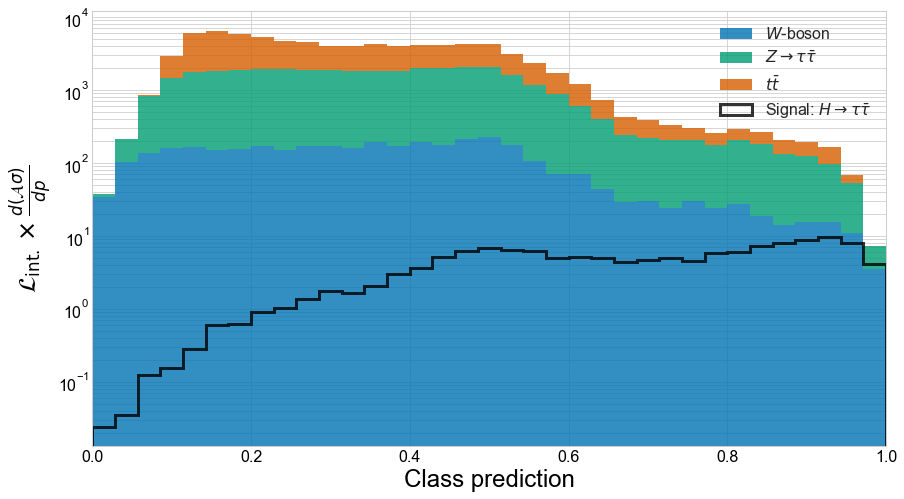

In [129]:
from lumin.plotting.results import plot_sample_pred
plot_sample_pred(val_df_tta)

Although not required for the HiggsML challenge, rather than simply cutting on the class prediction to get a signal bin for the signal hypothesis test (cut & count), one could instead use the shape of the distributions (shape analysis). The power of the analysis can be expected to increase with the number of bins used to capture the shape of the distributions, however one must consider the uncertainties on the bin fills due to limited Monte Carlo data being used to populate them. We can use `bin_binary_class_pred` to optimise the bin edges such that the uncertainty on the normalisation per bin per sample is kept below a specified percentage:

In [185]:
from lumin.inference.summary_stat import bin_binary_class_pred
edges = bin_binary_class_pred(val_df_tta, max_unc=0.15)
print(len(edges)-1, 'bins, with edges:', edges)

88 bins, with edges: [0.    0.036 0.108 0.136 0.154 0.171 0.188 0.201 0.211 0.224 0.233 0.243
 0.253 0.262 0.269 0.276 0.284 0.291 0.298 0.305 0.312 0.321 0.328 0.335
 0.342 0.349 0.355 0.361 0.367 0.373 0.378 0.382 0.387 0.391 0.396 0.401
 0.406 0.41  0.415 0.419 0.423 0.426 0.43  0.434 0.438 0.442 0.446 0.451
 0.454 0.458 0.462 0.466 0.469 0.473 0.476 0.48  0.484 0.488 0.492 0.495
 0.499 0.502 0.506 0.51  0.514 0.518 0.522 0.526 0.53  0.535 0.539 0.545
 0.55  0.556 0.562 0.569 0.577 0.585 0.593 0.603 0.612 0.622 0.639 0.659
 0.699 0.736 0.804 0.871 1.   ]


We can now pass these edges to our plotting function:

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


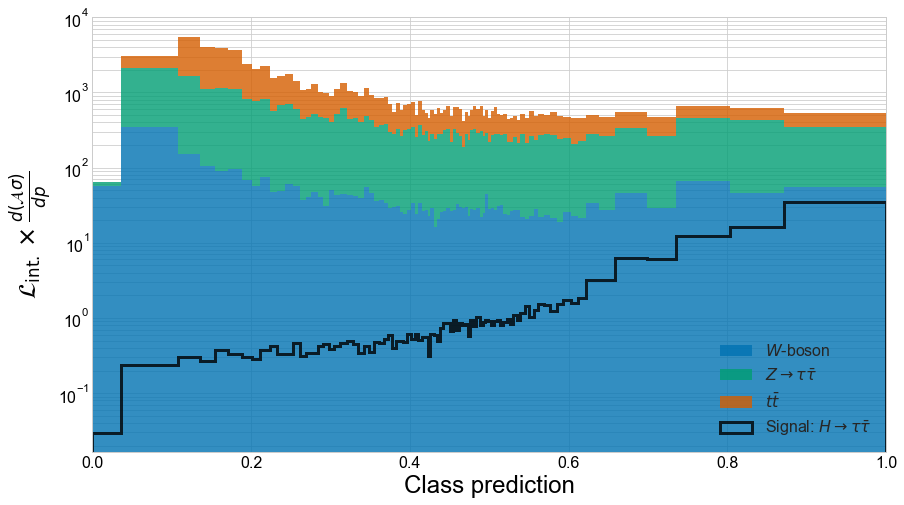

In [186]:
plot_sample_pred(val_df_tta, bins=edges)

Probably not necessary here, but just to show it off:

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative=

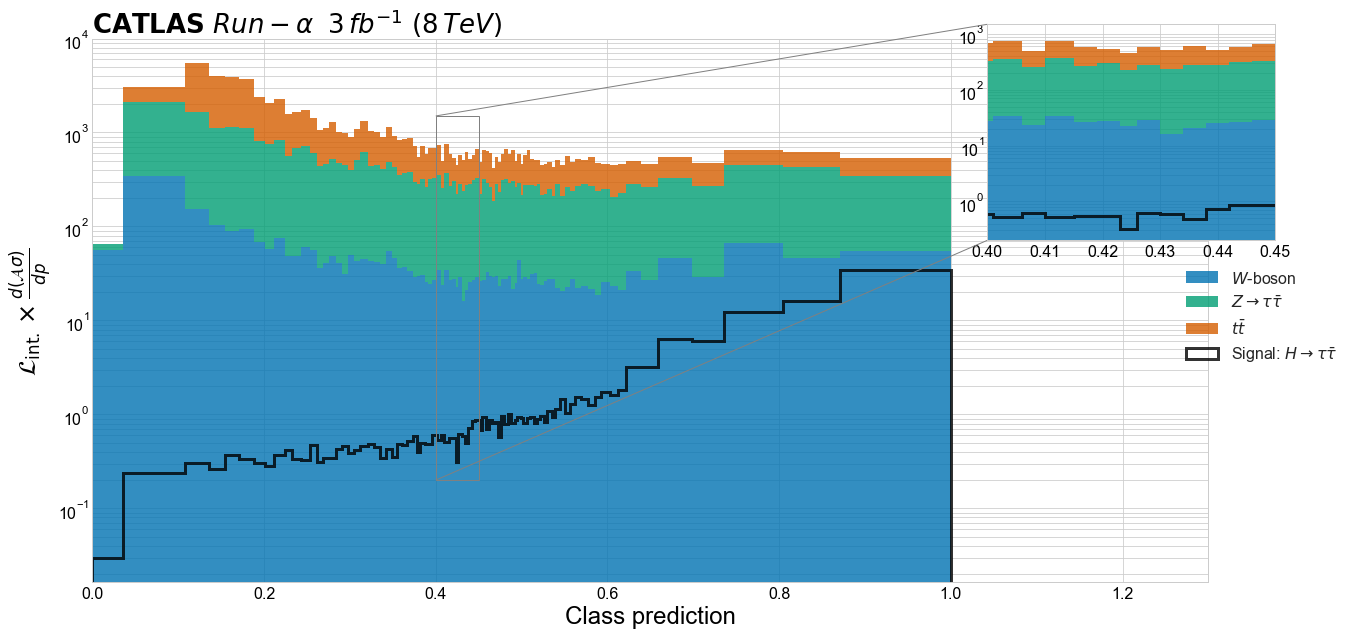

In [228]:
from lumin.plotting.plot_settings import PlotSettings
settings = PlotSettings(w_mid=20, h_mid=10, title=r'$\mathbf{CATLAS}\ \mathit{Run}-\alpha$' + '\t' + r'$3\,fb^{-1}\ (8\, TeV)$')
plot_sample_pred(val_df_tta, bins=edges, settings=settings, lim_x=(0,1.3),
                 zoom_args={'x':(0.4,0.45), 'y':(0.2, 1500), 'anchor':(0,0.25,0.95,1),
                            'width_scale':1, 'width_zoom':4, 'height_zoom':3})

## Interpretation 
It could be interesting to see what the multiclass approach learns differently to the binary classification method.

In [229]:
from lumin.nn.ensemble.ensemble import Ensemble
ensemble = Ensemble()
ensemble.load('weights/Multiclass_Classification')

In [230]:
from lumin.nn.data.fold_yielder import HEPAugFoldYielder
train_fy = HEPAugFoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


### Feature importance
In the same way as we used permutation importance to rank features with random forests, we can use the same technique to rank features with our ensemble.

Top ten most important features:
                        Feature  Importance  Uncertainty
0                   DER_sum_pt    1.709442     0.029805
1               PRI_jet_all_pt    0.797928     0.019899
2                 DER_mass_vis    0.259455     0.006161
3                  PRI_jet_num    0.219267     0.005247
4           DER_deltar_tau_lep    0.216117     0.006987
5                 DER_mass_MMC    0.186814     0.004862
6                     DER_pt_h    0.169187     0.005500
7  DER_mass_transverse_met_lep    0.126647     0.004476
8                   PRI_met_pt    0.110221     0.004278
9                   DER_pt_tot    0.109579     0.005505


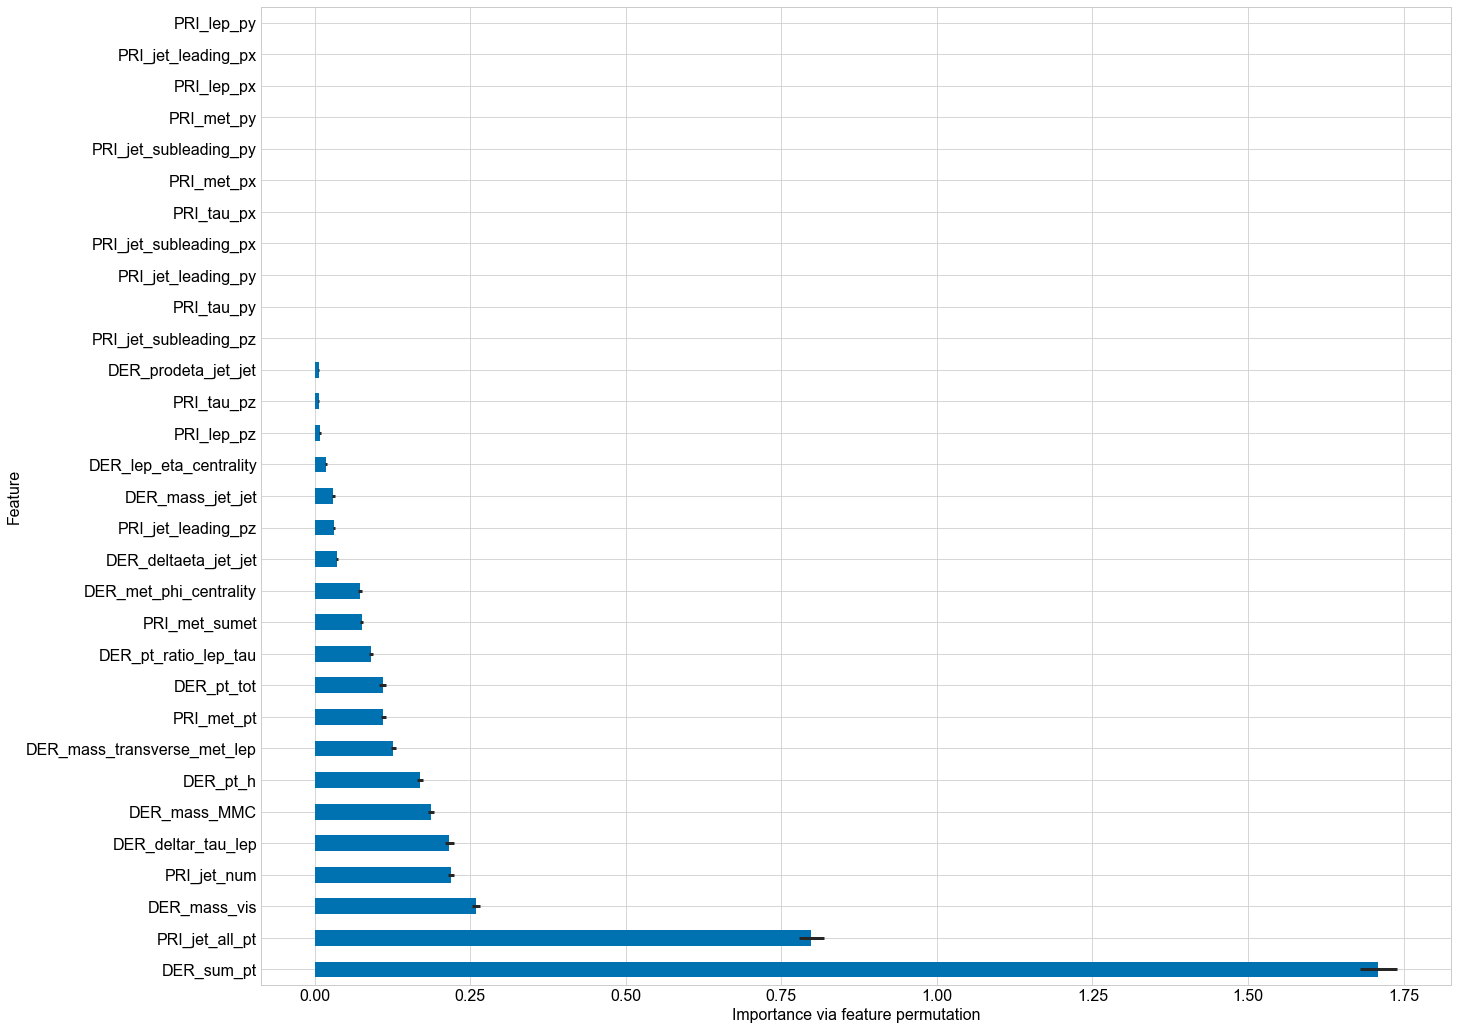

In [231]:
_ = ensemble.get_feat_importance(train_fy)

Interestingly, the ensemble mostly relies on high-level features, and seems to rely heavily on two features, rather than a spread of features like the binary classifier.

Currently, we're measuring importance via changes in weighted binary cross-entropy. Instead we can get the effect on the AMS by passing an `eval_metric`, (this takes a while, though).

Top ten most important features:
                        Feature  Importance  Uncertainty
0                   DER_sum_pt    0.181202     0.006751
1               PRI_jet_all_pt    0.181060     0.007398
2                 DER_mass_vis    0.115985     0.007313
3           DER_deltar_tau_lep    0.115239     0.006879
4                  PRI_jet_num    0.087559     0.007730
5  DER_mass_transverse_met_lep    0.070640     0.006587
6                 DER_mass_MMC    0.069385     0.006640
7                   PRI_met_pt    0.069309     0.006561
8                     DER_pt_h    0.049334     0.005620
9         DER_pt_ratio_lep_tau    0.041822     0.006483


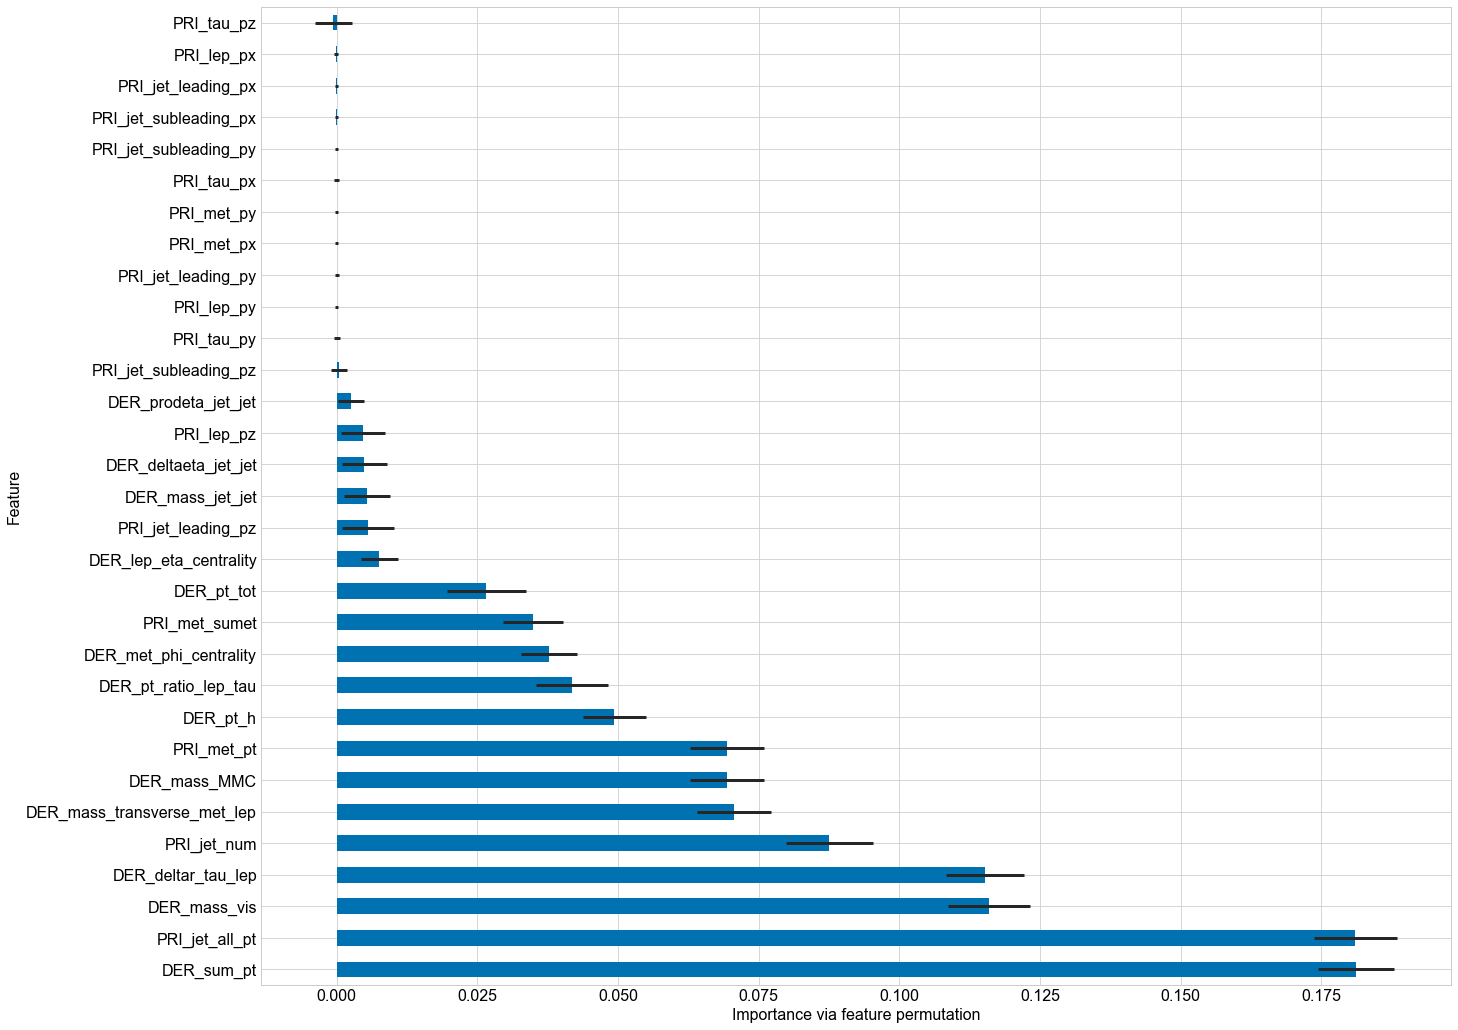

In [232]:
from lumin.nn.metrics.class_eval import AMS
_ = ensemble.get_feat_importance(train_fy, eval_metric=MultiAMS(n_total=250000, br=10,
                                    zero_preds=['pred_0', 'pred_1', 'pred_2'], one_preds=['pred_3'],
                                    targ_name='gen_target', weight_name='gen_orig_weight'))

Ok, so the classifier does actually make use of a range of features, and interestingly the uncertainties are a lot smaller than we saw for the binary classifier.

### Embeddings
We treated the number of jets (`PRI_jet_num`) as a categorical feature, but rather than one-hot encode it, we used an [entity embedding](https://arxiv.org/abs/1604.06737) matrix to learn a more optimal representation. We can take a look at this matrix and see what was learnt. If the binary classification example was ran first, then we would have loaded the initial embedding weights from a saved file, so we can also examine whether new weights were learnt, or if they remained similar.

In [235]:
_, m = ensemble[0]

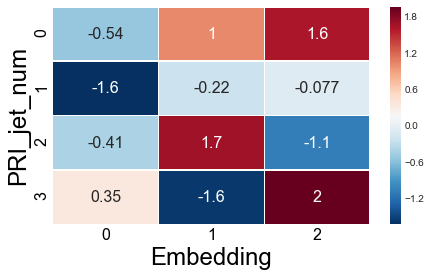

In [236]:
m.head.plot_embeds()

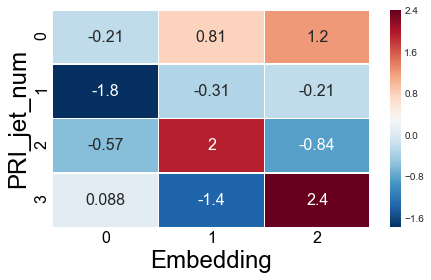

In [240]:
from lumin.plotting.interpretation import plot_embedding
import torch
plot_embedding(torch.load('weights/PRI_jet_num.h5'), 'PRI_jet_num')

The embedding weights seem to be pretty similar, and the jet multiplicity was ranked pretty high in importance, so we can assume that the weights offer a good encoding for the feature.

### Partial dependence
Another way to use our model rather than simply making decisions based the data, is to use to to better understand the data itself. In business, one could predict the influence that any handles that are available could have on some outcome. In high-energy physics, our available handles are quite limited; the collider is already built and difficult to modify. However it could be useful to have some information available to inform future decisions, or know where to concentrate algorithm development.

An example of how we can additionally use our model is plot the partial dependencies of the prediction on (pairs of) features. Basically this means taking a feature and working out how the prediction changes if everything else is kept the same and only the given feature is altered. `plot_1d_partial_dependence` and `plot_2d_partial_dependence` are wrapper functions for PDPbox, to handle the fact that our model expects pre-processed inputs, but we'd like to see the original data.

The PDPbox methods, however, only works for models with a single output, so we'll add an endcap to the model, to reduce the predictions to binary. Endcaps take a model as a parameter and then pass inputs to it, and then apply a function to the model outputs.

In [633]:
from lumin.nn.models.blocks.endcap import AbsEndcap

class Multiclass2Binary(AbsEndcap):
    @staticmethod
    def func(x:Tensor) -> Tensor:
        x = torch.exp(x)
        zero = torch.max(x[:,0:3], dim=1)[0]
        tup = torch.cat((zero[:,None], x[:,3][:,None]), dim=1)
        preds = torch.max(tup, dim=1)
        preds[0][preds[1]==0] = 1-preds[0][preds[1]==0]
        return preds[0]

In [623]:
m = ensemble[0][1]
data = val_fy.get_fold(0)['inputs']

In [624]:
df = pd.DataFrame(m.predict(data), columns=[f'{x}' for x in range(4)])
to_binary_class(df, [f'{x}' for x in range(3)], ['3'])

In [625]:
endcap = Multiclass2Binary(m)
df['pred_2'] = endcap.predict(data)

In [626]:
df.head()

,0,1,2,3,pred,pred_2
0,0.262042,0.037951,0.114143,0.585864,0.585864,0.585864
1,0.273140,0.000638,0.655217,0.071005,0.344783,0.344784
2,0.115082,0.743389,0.001969,0.139561,0.256611,0.256611
3,0.784824,0.001255,0.074611,0.139310,0.215176,0.215176
4,0.087999,0.000309,0.126837,0.784855,0.784855,0.784855


Seems to be working

In [627]:
from lumin.plotting.interpretation import plot_1d_partial_dependence, plot_2d_partial_dependence

In [628]:
train_fy.add_input_pipe_from_file('data/input_pipe.pkl')
train_df = train_fy.get_df(inc_inputs=True)

200000 candidates loaded


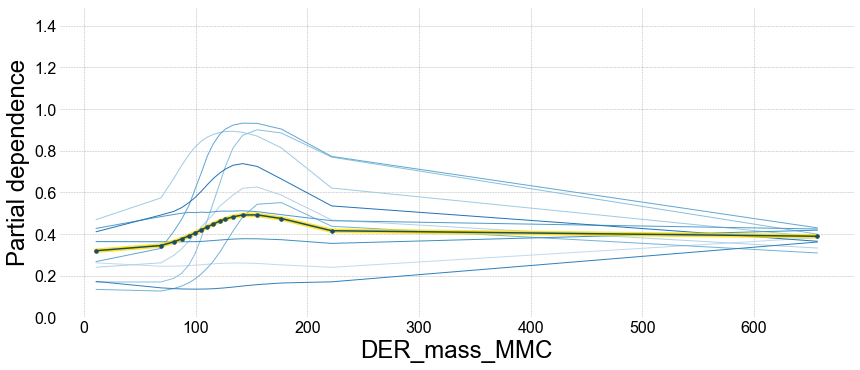

In [629]:
plot_1d_partial_dependence(endcap, train_df[cont_feats+cat_feats], 'DER_mass_MMC', input_pipe=input_pipe,
                           sample_sz=2000, weights=train_df.gen_weight, )

Here we plotted the partial dependence of the Higgs mass on the class prediction. This involved taking each event and changing the `DER_mass_MMC` to different values, whilst keeping all the other features the same, and feeding the altered events through our model and tracking the prediction changes. Rather than plotting one line for each event, they are instead clustered into 10 'types' of event.

Nearly all lines increase towards a signal prediction around the Higgs mass (125), but some lines rise earlier, or later. The yellow line indicates the median event.

We can try other features, too:

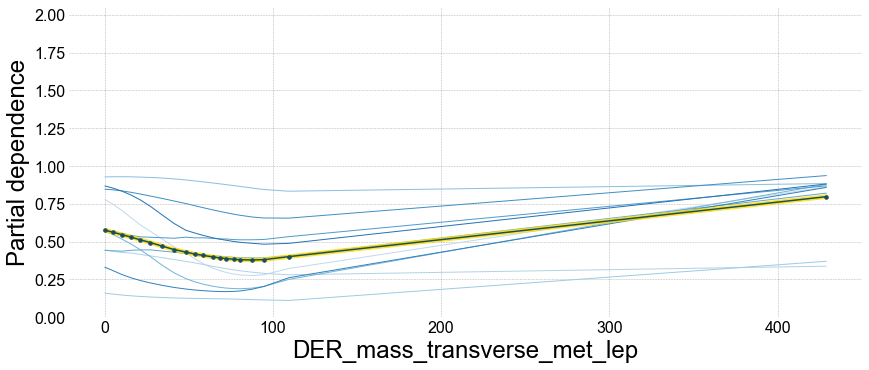

In [631]:
plot_1d_partial_dependence(endcap, train_df[cont_feats+cat_feats], 'DER_mass_transverse_met_lep', input_pipe=input_pipe,
                           sample_sz=2000, weights=train_df.gen_weight)

Or even get pair-wise partial dependencies

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'N'
  s)


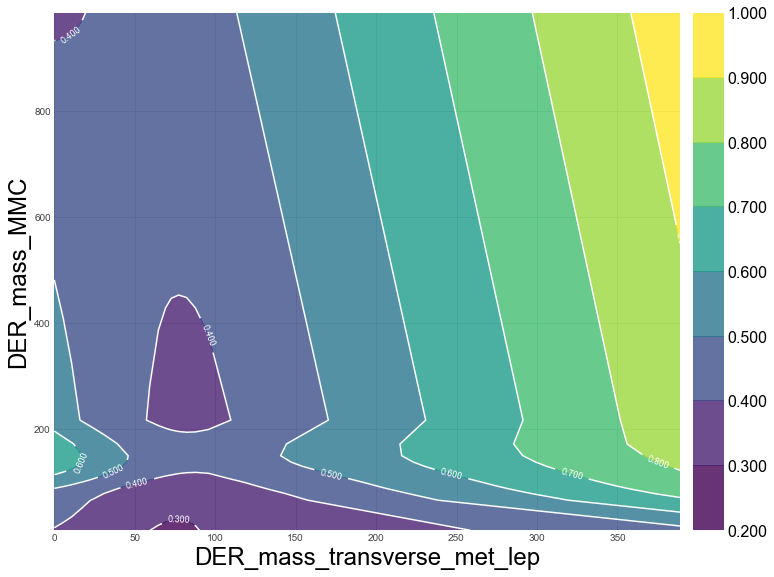

In [632]:
plot_2d_partial_dependence(endcap, train_df[cont_feats+cat_feats], ['DER_mass_transverse_met_lep','DER_mass_MMC'],
                           input_pipe=input_pipe, sample_sz=2000, weights=train_df.gen_weight)